Define a new method called aircrafts that receives no arguments and prints only the list of aircraft models (Names)i�r�c�r�a�f�.

In [1]:
import os
import pandas as pd
import requests
from zipfile import ZipFile
from typing import List, Dict, Union
from pydantic import BaseModel
from notebook_prototypes.distances import haversine_distance, Coordinates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
'''from langchain_openai import OpenAI, ChatOpenAI
import langchain'''
from IPython.display import Markdown, display
import seaborn as sns
#from pandasai import SmartDataframe
from ast import literal_eval

In [2]:
import pandas as pd
airlines_df = pd.read_csv('airlines.csv', on_bad_lines='skip')
airplanes_df = pd.read_csv('airplanes.csv', on_bad_lines='skip')
airports_df = pd.read_csv('airports.csv', on_bad_lines='skip')
routes_df =  pd.read_csv('routes.csv', on_bad_lines='skip')

In [4]:
'''# Helper functions for plotting flight routes on maps
def plot_route(source_airport, dest_airport, source_lat, source_lon, dest_lat, dest_lon, ax):
    """
    Plots a single flight route on the given axis.
    """
    # Plot the flight route
    ax.plot([source_lon, dest_lon], [source_lat, dest_lat], 'ro-', transform=ccrs.PlateCarree(), linewidth=1)
    
    # Add airport markers
    ax.plot(source_lon, source_lat, 'bo', markersize=4, transform=ccrs.PlateCarree())
    ax.plot(dest_lon, dest_lat, 'bo', markersize=4, transform=ccrs.PlateCarree())
    
    # Add airport labels
    #ax.text(source_lon + 0.5, source_lat + 0.5, source_airport, transform=ccrs.PlateCarree())
    #ax.text(dest_lon + 0.5, dest_lat + 0.5, dest_airport, transform=ccrs.PlateCarree())
'''

In [3]:
def departing_flights_country(country, internal=False, cutoff=1000.0): 
    """
    Retrieve and display information about departing flights from airports in a given country.

    Args:
        country (str): The name of the country for which departing flights will be retrieved.
        internal (bool, optional): If True, only internal flights (with destination in the same country) will be displayed. Defaults to False.
        cutoff (float, optional): The cutoff distance in kilometers. Routes with distances below this cutoff will be colored green. Defaults to 1000.0.

    Returns:
        None

    This method retrieves information about departing flights from airports in the specified country and displays it.
    It joins the routes and airports DataFrames to obtain flight information.
    It filters flights based on the given source country and optionally on whether they are internal.
    If internal is True, only flights with the same source and destination country are displayed.
    If there are no departing flights or no internal flights, appropriate messages are printed.
    """
    def plot_all_routes_colors(df, cutoff):
        """
        Plots all flight routes from the given DataFrame on a map.

        Args:
            df (DataFrame): DataFrame containing flight route information.
            cutoff (float): The cutoff distance in kilometers. Routes with distances below this cutoff will be colored green.

        Returns:
            None
        """
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        for _, row in df.iterrows():
            source_airport = row['Source airport']
            dest_airport = row['Destination airport']
            source_lat = row['Source_lat']
            source_lon = row['Source_lon']
            dest_lat = row['Dest_lat']
            dest_lon = row['Dest_lon']
            distance = row['Distance']

            color = 'green' if distance < cutoff else 'red'

            ax.plot([source_lon, dest_lon], [source_lat, dest_lat], marker='o', color=color, transform=ccrs.PlateCarree(), linewidth=1)
            ax.plot(source_lon, source_lat, 'bo', markersize=4, transform=ccrs.PlateCarree())
            ax.plot(dest_lon, dest_lat, 'bo', markersize=4, transform=ccrs.PlateCarree())

        max_lon = max(df['Source_lon'].max(), df['Dest_lon'].max())
        min_lon = min(df['Source_lon'].min(), df['Dest_lon'].min())
        max_lat = max(df['Source_lat'].max(), df['Dest_lat'].max())
        min_lat = min(df['Source_lat'].min(), df['Dest_lat'].min())
        ax.set_extent([min_lon - 5, max_lon + 5, min_lat - 5, max_lat + 5], crs=ccrs.PlateCarree())

        plt.title('Flight Routes')
        plt.show()

    # Join on Source airport
    airport_info_1 = routes_df[['Source airport', 'Destination airport']].join(airports_df.set_index('IATA')[['Country', 'Latitude', 'Longitude']], on='Source airport')
    # Rename the column
    airport_info_1.rename(columns={'Country': 'Source Country', 'Latitude':'Source_lat', 'Longitude': 'Source_lon'}, inplace=True)
    airport_info_1[["Source Country", "Source_lat", "Source_lon", "Source airport", "Destination airport"]]
    
    airport_info_2 = airport_info_1.join(airports_df.set_index('IATA')[['Country', 'Latitude', 'Longitude']], on='Destination airport')
    # Rename the column if needed
    airport_info_2.rename(columns={'Country': 'Destination Country','Latitude':'Dest_lat', 'Longitude': 'Dest_lon'}, inplace=True)
    # Drop the additional index columns
    airport_info_2 = airport_info_2.reset_index(drop=True)
    
    # Filter flights based on the given source country
    source_flights = airport_info_2[airport_info_2['Source Country'] == country]
    source_flights = source_flights[~source_flights.duplicated()]

    del airport_info_1, airport_info_2

    # We only want to count each route 1 time - let's deal with this
    # Create a new column 'Route' that represents the route in a direction-agnostic way
    source_flights['Route'] = source_flights.apply(lambda x: '-'.join(sorted([x['Source airport'], x['Destination airport']])), axis=1)

    # Drop duplicates based on the 'Route' column
    source_flights = source_flights.drop_duplicates(subset=['Route'])

    # Drop the 'Route' column if you don't need it anymore
    source_flights = source_flights.drop('Route', axis=1)

    # Get coordinates for source and destination airports
    source_coords = source_flights.apply(lambda row: Coordinates(lat=row['Source_lat'], lon=row['Source_lon']), axis=1)
    dest_coords = source_flights.apply(lambda row: Coordinates(lat=row['Dest_lat'], lon=row['Dest_lon']), axis=1)
    # Calculate distances for each flight
    source_flights['Distance'] = [haversine_distance(src, dest) for src, dest in zip(source_coords, dest_coords)]

    if internal:
        # Filter for internal flights (destination in the same country)
        source_flights = source_flights[source_flights['Source Country'] == source_flights['Destination Country']]

    # Check if there are any flights to display
    if not source_flights.empty:
        if internal:
            print(f"Internal flights from {country} to destinations in the same country:")
        else:
            print(f"All flights from {country}:")

        plot_all_routes_colors(source_flights, cutoff=cutoff)

    else:
        print(f"No internal flights.")




All flights from Italy:


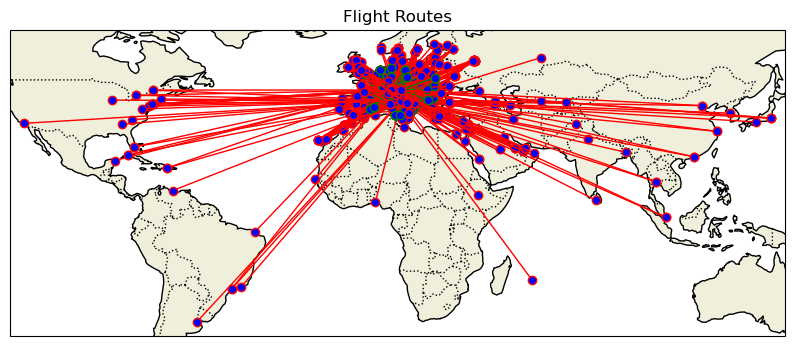

In [5]:
departing_flights_country('Italy')